In [1]:
import os
import nibabel as nib
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt

from utils import iliopsoas_seg_net, largest_connected_components, normalize, load_landmarks

Using TensorFlow backend.


In [2]:
# add your paths

path_to_model_weights = os.path.join(os.getcwd(), 'iliopsoas_muscle_model.h5')
path_to_data = os.path.join(os.getcwd(), 'data/ESS3TE4SJ3DEP5C5')

Predicting left iliopsoas segmentation...
Predicting right iliopsoas segmentation...


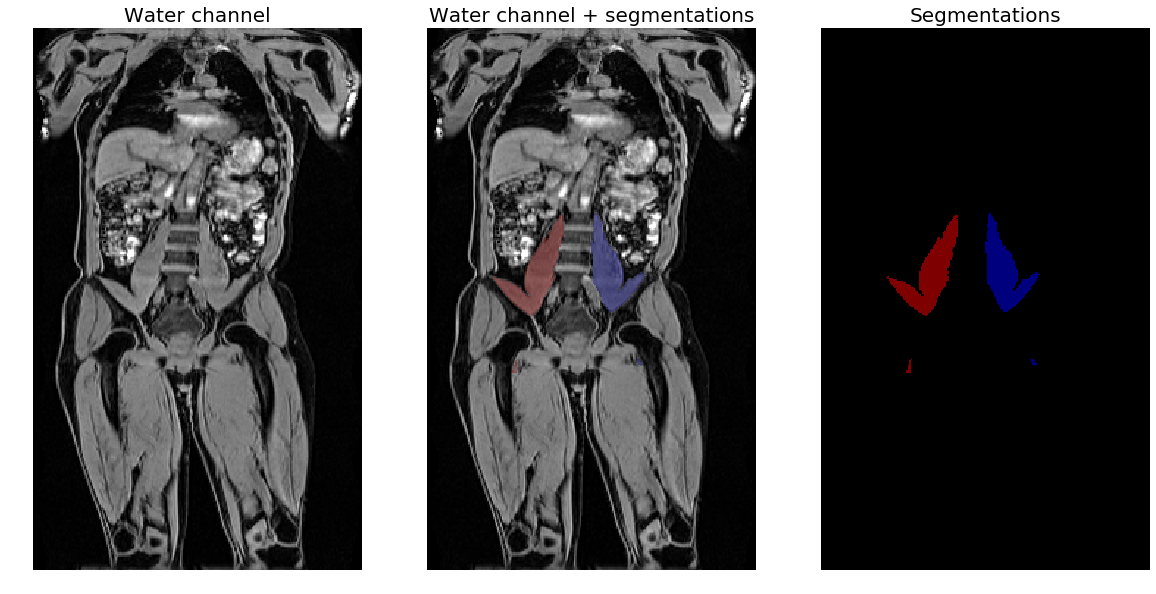

In [6]:
os.chdir(path_to_data)
img = nib.load('nifti/water.nii.gz')
img_data = img.get_fdata()
x, y, z = img_data.shape

mask = nib.load('analysis/mask.body.nii.gz')
landmarks = load_landmarks()
torso_centre_height = (landmarks['shoulder']['z'] + landmarks['hip']['z']) // 2
centre_body = ((landmarks['hip']['right'][0] + landmarks['hip']['left'][0]) / 2).astype('uint8')
iliopsoas_muscles = np.zeros([x, y, z], dtype='uint8')
hdr_float32 = img.header.copy()
hdr_float32.set_data_dtype('float32')
    
xc, yc, zc = (96, 96, 192)
model = iliopsoas_seg_net((xc, yc, zc, 1))
# model.summary()
model.load_weights(path_to_model_weights)
i = 1

for hand in ['left', 'right']:
    print('Predicting {} iliopsoas segmentation...'.format(hand))
    crange = {
        'x': slice(0, xc + min(0, x - (centre_body + xc))) if hand == 'left' else slice(0 - min(0, centre_body - xc), xc),
        'y': slice(0, yc),
        'z': slice(0 - min(0, landmarks['hip']['z'] - torso_centre_height // 4),
                   zc + min(0, z - (zc + landmarks['hip']['z'] - torso_centre_height // 4)))}
    drange = {
        'x': slice(centre_body, min(x, centre_body + xc)) if hand == 'left' else slice(max(0, centre_body - xc), centre_body),
        'y': slice((y - yc) // 2, y - (y - yc) // 2),
        'z': slice(max(0, landmarks['hip']['z'] - torso_centre_height // 4), zc + landmarks['hip']['z'] - torso_centre_height // 4)}

    img_data_roi = np.zeros((xc, yc, zc), dtype='float32')
    img_data_roi[crange['x'], crange['y'], crange['z']] = img_data[drange['x'], drange['y'], drange['z']]
    img_data_roi = normalize(img_data_roi)
    predicted_roi = np.squeeze(model.predict(img_data_roi[np.newaxis, :, :, :, np.newaxis]))
    predicted_roi = predicted_roi# > 0.3
    predicted = np.zeros([x, y, z], dtype='float32')
    predicted[drange['x'], drange['y'], drange['z']] = predicted_roi[crange['x'], crange['y'], crange['z']]
    predicted_roi = nd.binary_fill_holes(predicted_roi, structure=nd.generate_binary_structure(3, 1))
    predicted_roi = largest_connected_components(predicted_roi)

    file_name = 'iliopsoas_muscle_manual_left.nii.gz' if hand == 'left' else 'iliopsoas_muscle_manual_right.nii.gz'
    predicted = np.zeros([x, y, z], dtype='uint8')
    predicted[drange['x'], drange['y'], drange['z']] = predicted_roi[crange['x'], crange['y'], crange['z']]
    nib.Nifti1Image(predicted, mask.affine, mask.header).to_filename(
        'analysis/mask.iliopsoas_muscle_{}.nii.gz'.format(hand))
    iliopsoas_muscles += np.int(i) * predicted
    i += 1
nib.Nifti1Image(iliopsoas_muscles, img.affine, img.header).to_filename('analysis/mask.iliopsoas_muscle.nii.gz')

plot_ipm = iliopsoas_muscles.astype('float')
plot_ipm[plot_ipm == 0] = 'nan'
plt.subplots(1,3,figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(np.rot90(img_data[:,73,:]), 'gray', vmax=800)
plt.title('Water channel', fontsize=20)
plt.axis('off')
    
plt.subplot(1,3,2)
plt.imshow(np.rot90(img_data[:,73,:]), 'gray', vmax=800)
plt.imshow(np.rot90(plot_ipm[:,73,:]), 'jet', alpha = 0.4, interpolation='none') 
plt.title('Water channel + segmentations', fontsize=20)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(np.rot90(img_data[:,73,:])*0, 'gray', vmax=800)
plt.imshow(np.rot90(plot_ipm[:,73,:]), 'jet', interpolation='none')
plt.title('Segmentations', fontsize=20)
plt.axis('off')

plt.show() 